In [1]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Recognizing traffic signs

!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2020-06-26 13:35:36--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  58.3MB/s    in 4.6s    

2020-06-26 13:35:41 (57.5 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [3]:
#Exploration

train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

In [4]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

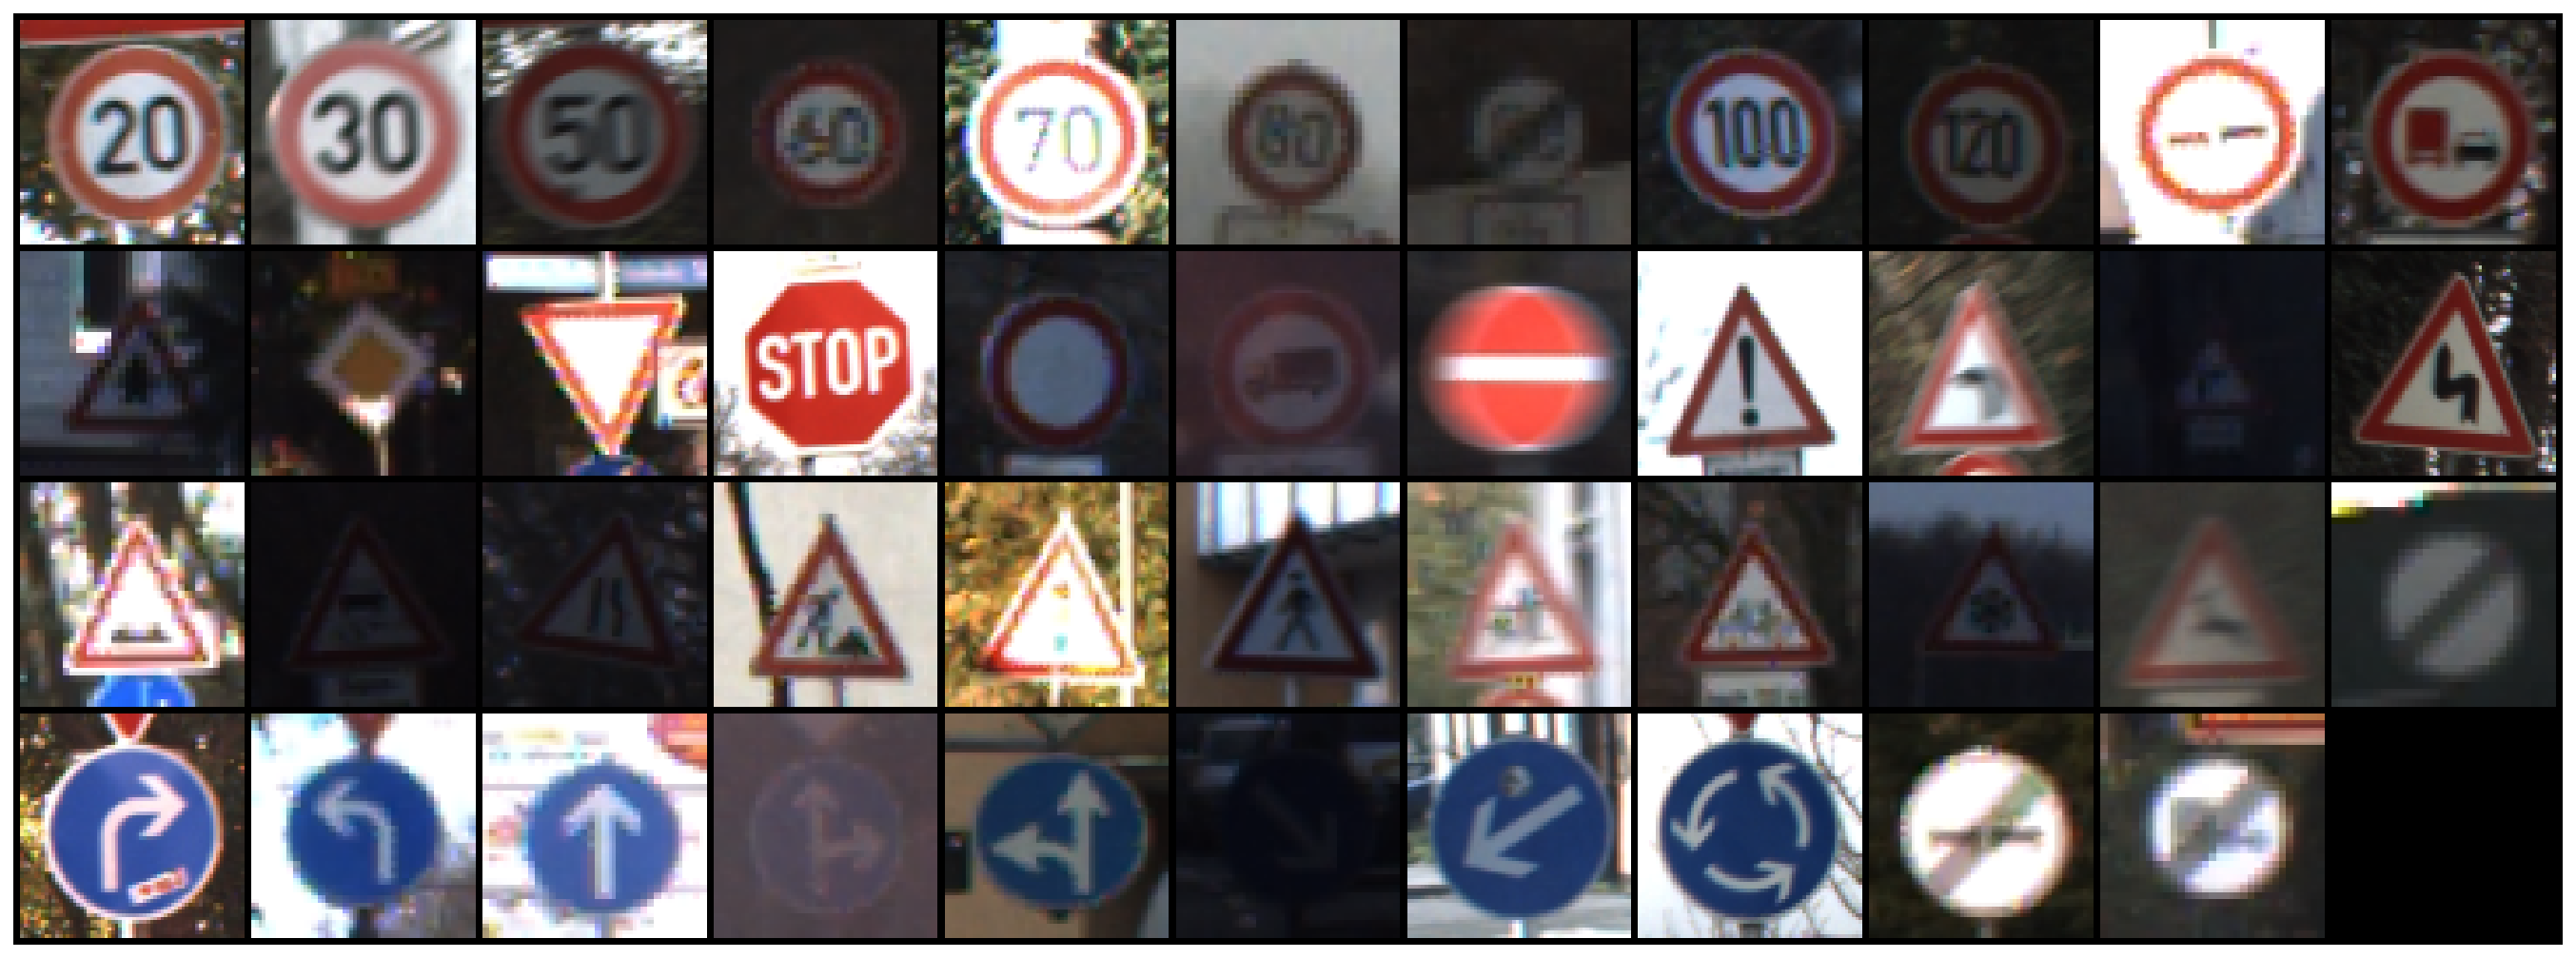

In [5]:
#Following are some of the examples for each traffic sign:

sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

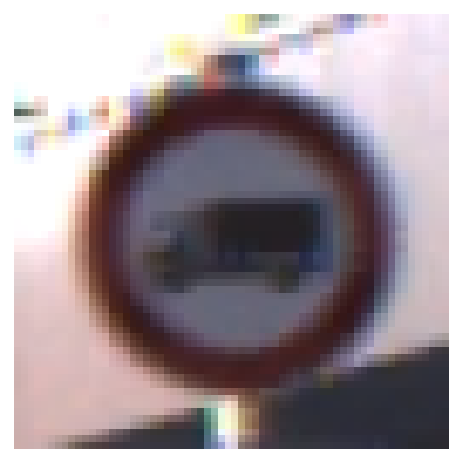

In [6]:
#this is a single sign
img_path = glob(f'{train_folders[16]}/*ppm')[1]
show_image(img_path)


In [7]:
#Building a dataset

class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [12, 13, 14, 17]

In [8]:
#Let us copy the images files to a new directory,
#so it’s easier to use the Torchvision’s dataset helpers. 

!rm -rf data
DATA_DIR = Path('data')
DATASETS = ['train', 'val', 'test']
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [11]:
#now We’ll reserve 80% of the images for training,
# 10% for validation, and 10% test for each class. 
#We’ll copy each image to the correct dataset directory:

for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)
  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )
  dataset_data = zip(DATASETS, ds_split)
  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')


priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


In [12]:
#image augmentation 
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [13]:
#We’ll create a PyTorch dataset for each image dataset folder and data loaders for easier training:

image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}
data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4)
  for d in DATASETS
}

In [14]:
#We’ll also store the number of examples in each dataset and class names for later:

dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes
dataset_sizes

{'test': 1170, 'train': 5907, 'val': 1178}

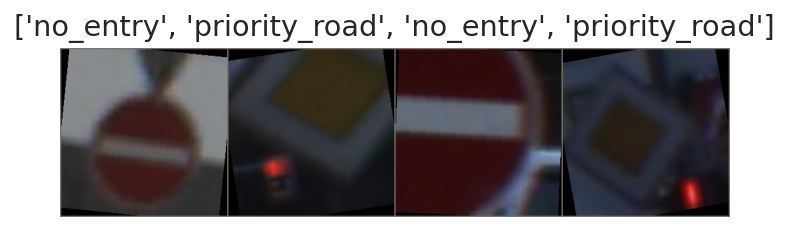

In [15]:
#some examples of the images with applied transformations. 
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')
inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


In [16]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)
  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)
  return model.to(device)

In [17]:
#Let’s create an instance of our model:

base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [18]:
#Training
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  scheduler.step()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)
  history = defaultdict(list)
  best_accuracy = 0
  for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],
      loss_fn,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc
  print(f'Best val accuracy: {best_accuracy}')
  model.load_state_dict(torch.load('best_model_state.bin'))
  return model, history

In [21]:
#Let’s train our first model:

%%time
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)


Epoch 1/3
----------
Train loss 0.31235429798249725 accuracy 0.8953783646521077
Val   loss 0.0088401198387146 accuracy 0.9974533106960951

Epoch 2/3
----------
Train loss 0.11130629056155399 accuracy 0.9646182495344506
Val   loss 0.002758799569081452 accuracy 0.999151103565365

Epoch 3/3
----------
Train loss 0.06807686243907435 accuracy 0.9783307939732521
Val   loss 0.000735025890802933 accuracy 1.0

Best val accuracy: 1.0
CPU times: user 5min 46s, sys: 2min 26s, total: 8min 13s
Wall time: 8min 20s


In [22]:
#Evaluation
#Let’s see some predictions on traffic signs from the test set:

def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')
        if images_handeled == n_images:
          return

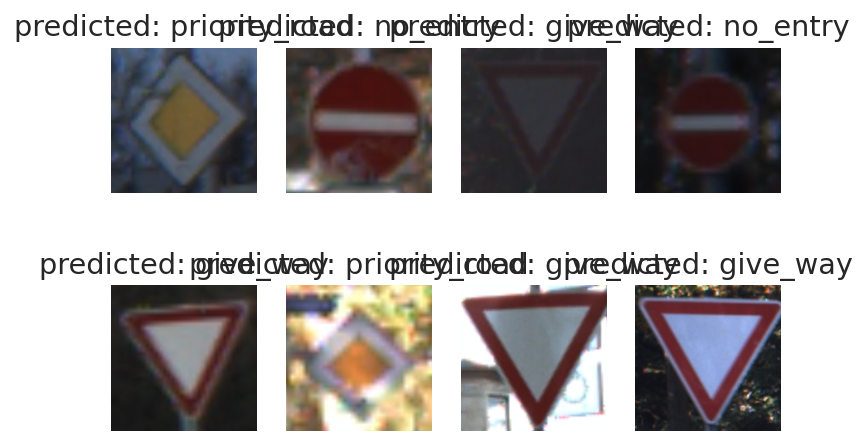

In [25]:
show_predictions(base_model, class_names, n_images=8)

Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: /content/stop-sign.jpg
100% 77.3k/77.3k [00:00<00:00, 31.3MB/s]


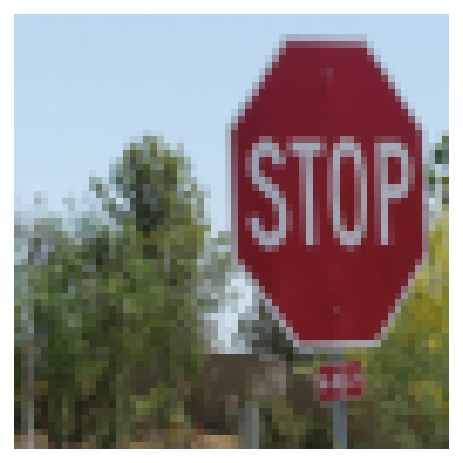

In [26]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
show_image('stop-sign.jpg')

In [27]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)
  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()
pred = predict_proba(base_model, 'stop-sign.jpg')
pred

array([0.00203492, 0.13834956, 0.00115502, 0.8584605 ], dtype=float32)

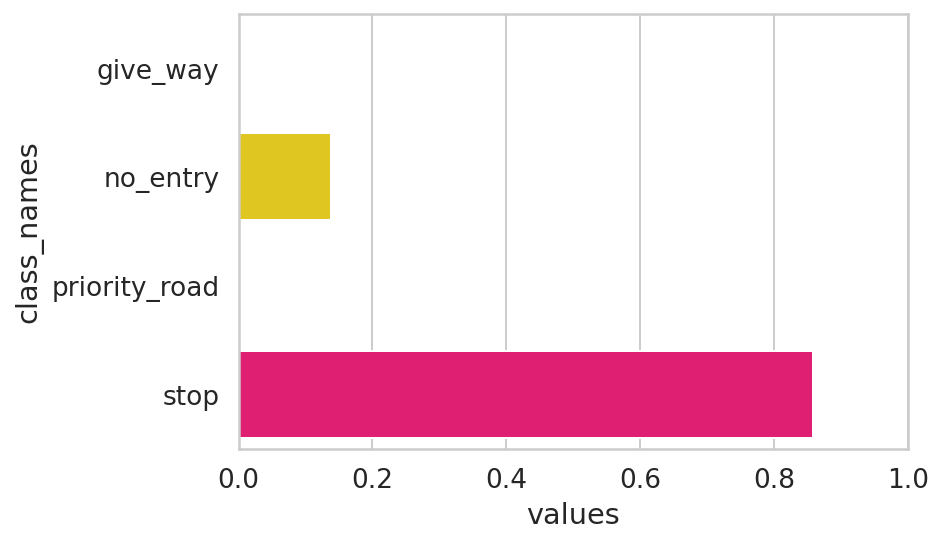

In [28]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);
show_prediction_confidence(pred, class_names)

Downloading...
From: https://drive.google.com/uc?id=1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u
To: /content/unknown-sign.jpg
100% 41.4k/41.4k [00:00<00:00, 15.1MB/s]


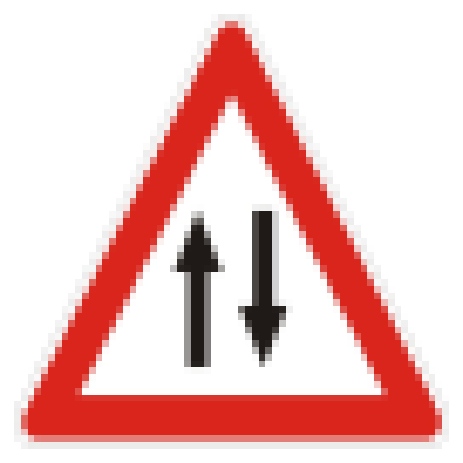

In [29]:
#Classyfing unknown traffic sign
!gdown --id 1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u
show_image('unknown-sign.jpg')

In [30]:
pred = predict_proba(base_model, 'unknown-sign.jpg')
pred

array([9.9464947e-01, 1.5687748e-04, 4.8520342e-03, 3.4159474e-04],
      dtype=float32)

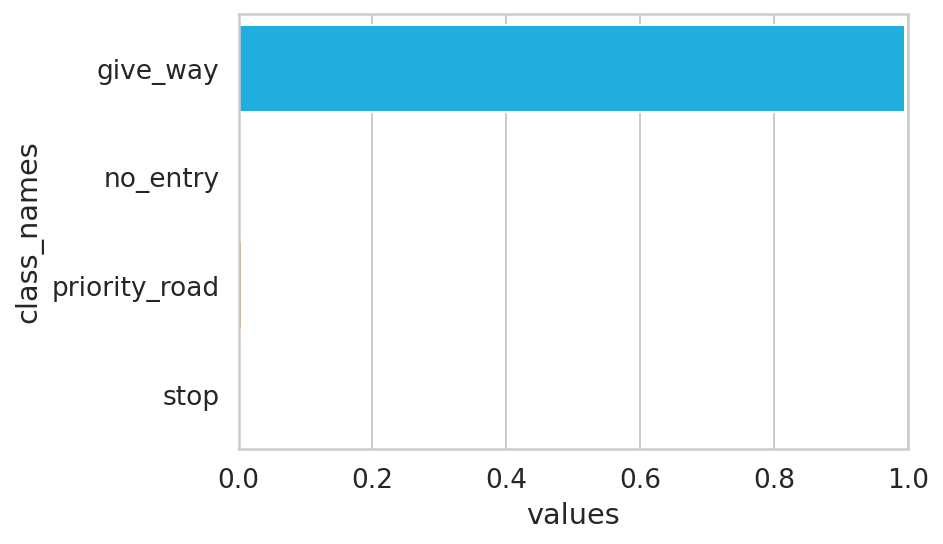

In [31]:
show_prediction_confidence(pred, class_names)

In [33]:
#creating an enhanced model
%%time
enchanced_model = create_model(len(class_names))
enchanced_model, history = train_model(enchanced_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------
Train loss 0.2861123131228688 accuracy 0.9029964448958863
Val   loss 0.010562354730347456 accuracy 0.9974533106960951

Epoch 2/3
----------
Train loss 0.12132246993083605 accuracy 0.9619095987811072
Val   loss 0.0023800603413985945 accuracy 0.999151103565365

Epoch 3/3
----------
Train loss 0.07915556117054895 accuracy 0.9744371085153208
Val   loss 0.0033153962280790686 accuracy 0.99830220713073

Best val accuracy: 0.999151103565365
CPU times: user 5min 47s, sys: 2min 25s, total: 8min 13s
Wall time: 8min 20s


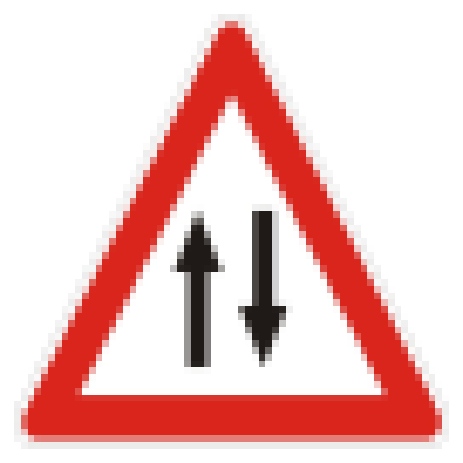

In [34]:
show_image('unknown-sign.jpg')

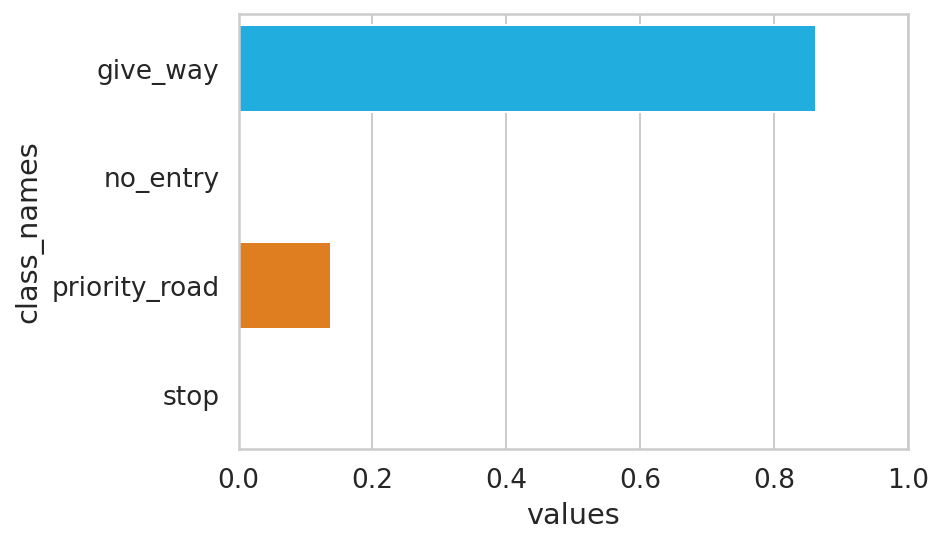

In [35]:
pred = predict_proba(enchanced_model, 'unknown-sign.jpg')
show_prediction_confidence(pred, class_names)

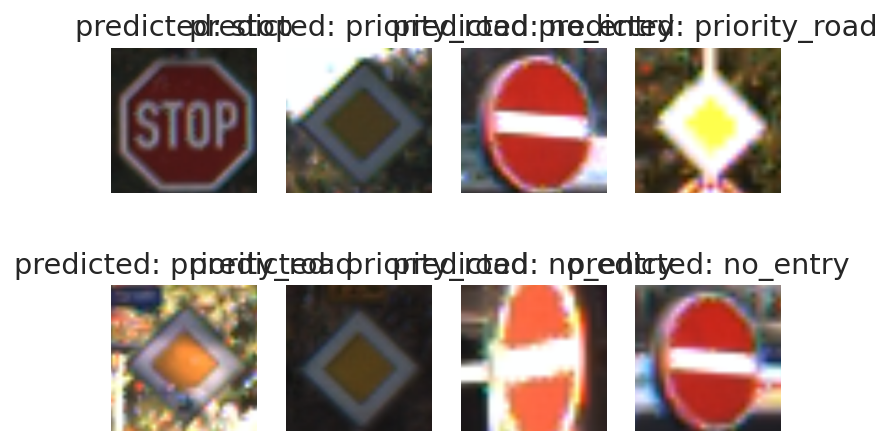

In [37]:
show_predictions(enchanced_model, class_names, n_images=8)